Anomaly detection for drifting buoy data is challenging because the data characteristics depend on many factors: reporting frequency, position error, 

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import sys
sys.path.append('../../drifter')
from importlib import reload
import os
import utilities.cleaning as clean
import utilities.interpolation as interp
import proplot as pplt
from scipy.stats import trimboth
import scipy.stats as stats

def trimmed_std(x):
    return trimboth(x, 0.1).std()

def trimmed_mean(x):
    return trimboth(x, 0.1).mean()



clean = reload(clean)
interp = reload(interp)

In [2]:
dataloc = '../../data/adc_dn_tracks/'
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']

metadata = pd.read_csv(dataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]

# Optional: focus in on only a portion of the tracks
begin = '2019-10-15-00 00:00'
end = '2022-01-01 00:00'
    
file_present = np.array([f + '.csv' in files for f in metadata.filename])
metadata = metadata.loc[file_present].copy()
metadata.set_index('Sensor ID', inplace=True)

# Maximum gap in hours for the interpolation algorithm
max_dt = 2

# Pad for interpolation, so that the first and last values aren't missing.
margin = pd.to_timedelta('6H')
# Folder with the drift tracks from 
# the Arctic Data Center (Bliss et al. 2021)
# https://arcticdata.io/catalog/view/urn%3Auuid%3A2b859a39-cada-4147-819a-dc222f6f89a3
dataloc = '../../data/adc_dn_tracks/'
saveloc = '../data/mosaic_interpolated/'
# Maximum gap in hours for the interpolation algorithm
max_dt = 2

# Compute uncertainty threshold for splines?
recompute_thresh = False

# Pad for interpolation, so that the first and last values aren't missing.
margin = pd.to_timedelta('6H')

# Optional: focus in on only a portion of the tracks
begin = '2019-10-01 00:00'
end = '2022-01-01 00:00'

# Read in the files, including the metadata file
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']

metadata = pd.read_csv(dataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
    
file_present = np.array([f + '.csv' in files for f in metadata.filename])
metadata = metadata.loc[file_present].copy()
metadata.set_index('Sensor ID', inplace=True)

buoy_data = {}
for file in files:
    data = pd.read_csv(dataloc + file, index_col='datetime', parse_dates=True)

    # Apply checks for duplicate dates and duplicate positions
    # TBD: add step to count the number of checks
    # Could also retain the duplicate flag until the end
    data['date_flag'] = clean.check_dates(data, date_index=True)
    data['dupl_flag'] = clean.check_duplicate_positions(data, date_index=True, pairs_only=True)
    data = data.loc[(data['date_flag'] + data['dupl_flag']) < 1, ['latitude', 'longitude']].copy()        

    # Align data to nearest 5 minutes via interpolation
    buoy = file.replace('.csv', '').split('_')[-1]
    buoy_data[buoy] = interp.regrid_buoy_track(data, precision='10min')

# Based on comparison with co-located sites, all the V buoys have time indices offset by 8 hours.
for buoy in ['2019V1', '2019V2', '2019V3', '2019V4', '2019V5']:
    buoy_data[buoy].index = buoy_data[buoy].index - pd.to_timedelta('8H')
# Buoys 2019P112-114 have problems that need to be cleaned individually
buoy_data = {buoy: buoy_data[buoy] for buoy in buoy_data if buoy not in ['2019P112', '2019P113', '2019P114', '2019P119']}

In [3]:
interval_minutes = {}
varying_freq = 0
buoys = []
for buoy in buoy_data:
    date = pd.Series(buoy_data[buoy].index)
    interval_minutes[buoy] = pd.Series(((date - date.shift(1)).dt.total_seconds()/60).values, index=date)
    interval_minutes[buoy] = pd.to_timedelta(interval_minutes[buoy].resample('7D').median(),
                                             unit='min').round('5min').dt.total_seconds()/60
    if min(interval_minutes[buoy]) > 120:
        print(buoy)
    else:
        buoys.append(buoy)
    if len(np.unique(interval_minutes[buoy].dropna())) > 1:
        varying_freq += 1

2019I2
2020P214
2020P223
2019F1
2020P211
2020T60
2019I3
2019I1
2019P22
2019T47
2020P210
2019I4


In [4]:
for buoy in buoy_data:
    buoy_data[buoy]['sampling_interval'] = interval_minutes[buoy].reindex_like(buoy_data[buoy], method='ffill')
    buoy_data[buoy] = buoy_data[buoy].loc[buoy_data[buoy]['sampling_interval'] <= 120]

In [5]:
# calculate Z-score of speed
buoy_data_withz = {}
for buoy in buoys:
    buoy_df = clean.calc_speed_for_outlier_check(buoy_data[buoy], date_index=True)
    buoy_df = buoy_df.loc[buoy_df['sampling_interval'] <= 120]
    if len(buoy_df) > 24*14: # replace with interval-aware version
        buoy_df['flag'] = 0
        for idx in range(2):
            trim_std = buoy_df.where(buoy_df.flag==0).speed.rolling('1D', center=True).apply(trimmed_std)
            trim_mean = buoy_df.where(buoy_df.flag==0).speed.rolling('1D', center=True).apply(trimmed_mean)
            z = (buoy_df.speed - trim_mean)/trim_std
            buoy_df.loc[np.abs(z) > 4, 'flag'] = 1
        print(buoy, buoy_df.flag.sum())
        buoy_df['z'] = z
        buoy_data_withz[buoy] = buoy_df.copy()
        

2019R9 3
2019P142 4
2019T66 10
2020P164 3
2019R8 1
2020P170 3
2019P203 11
2019P91 34
2020P176 1
2019P151 6
2020P171 16
ASFS50UCB4 5
2020P162 0
2020P233 3
2019O4 47
2020S97 1
2019T67 3
2019P143 3
2019S87 0
2019P137 2
ASFS30UCB5 0
2020P163 3
2019O7 6
2020T84 2
2020P178 5
ASFS30UCB4 1
2020P174 4
2020T81 1
2020R10 1
2019S94 3
2019O2 15
2019T70 3
2019P153 0
2020P230 1
2020P236 2
2019O3 47
2019P138 0
2019P126 0
2019P161 0
2020P220 28
2020O10 366
2019P187 4
2019P140 2
2019P199 10
2019P146 1
2019O6 37
2020T74 6
2019P125 20
2019T56 0
2020P177 2
2020R21 0
2019T68 1
2019P152 2
ASFS50UCB3 0
2019P92 59
2020T85 1
2019V4 3
2020P228 5
2019P189 0
2020P172 6
2019F3 0
2019P90 44
2019P102 29
2020P225 3
2019P139 8
2020T78 2
2019M30 3
2019P88 46
2019P105 28
2020E1 3
2020S108 5
2019P195 13
2020M23 6
2019V2 3
2019S96 3
2020P180 0
2020P226 1
2019P192 4
2020P168 0
2019P183 5
2020P231 2
2019P206 8
2019T72 2
2019P156 2
2020P217 10
2019P128 3
2019P157 2
2020P160 0
2019P191 4
2019P209 5
2019P196 3
2019S90 0
2019S84

In [6]:
buoy_data = {b: buoy_data_withz[b] for b in buoy_data_withz}

(Speed calculation: min of fwd and bwd difference except at endpoints)

Potential outliers are identified by converting speed into a psuedo $Z$-score by subtracting the 1-day centered trimmed mean and dividing the result by the trimmed standard deviation. In both cases, the trimming functions removes the highest and lowest 10\% of the data before calculating the statistic. Observations with absolute $Z$-scores higher than 3 are flagged as potential outliers.

$$Z = \frac{|U| - \langle |U| \rangle_{0.1}}{\sigma_{0.1} |U|}$$

(Figure: speed, Z, qq-plot)

Next, we compare the difference in position and speed to a local natural cubic spline interpolation. The natural cubic spline interpolation is fit to data in a centered 2-day window surrounding a chosen observation. The interpolation is carried out simultaneously on $X$, $Y$, and $|U|$. The test statistics are the differences $\Delta X = \sqrt{(X - \hat X)^2 + (Y - \hat Y)^2}$ and $\Delta U = |U| - \hat{|U|}$.

In order to evaluate the test statistics, we take a random sample of $n=100$ dates and calculate $\Delta X$ and $\Delta U$ for each of these dates.
Examination of the resulting histograms shows that $\Delta U$ is approximately $t$-distributed. 
We calculate best-fit parameters for each buoy, then using the point-percentile function estimate lower and upper bounds such that the probability that $\Delta U$ is within the bounds is 1-$\alpha$ = 0.999. Observations outside of these empirical upper and lower bounds are flagged as outliers.

On the other hand, $\Delta X$ is strictly nonnegative and right-skewed, but the distribution is unclear.
We calculate the sample interquartile range (IQR) and median ($m$), and consider any value larger than $m + 2.5 \times IQR$ to be an outlier. 

If either $\Delta X$ or $\Delta U$ is flagged as an outlier, the observation is masked.




(Question: are the position and speed differences actually chi2 distributed?)

(Figure: local interpolation error)

In [302]:
date = pd.to_datetime('2020-05-01 14:00:00')
margin = pd.to_timedelta('24H')
buoy_df = buoy_data[buoy]
test = clean.fit_splines(date, buoy_df.loc[slice(date-margin, date+margin)], 'x', 'y', 'speed')

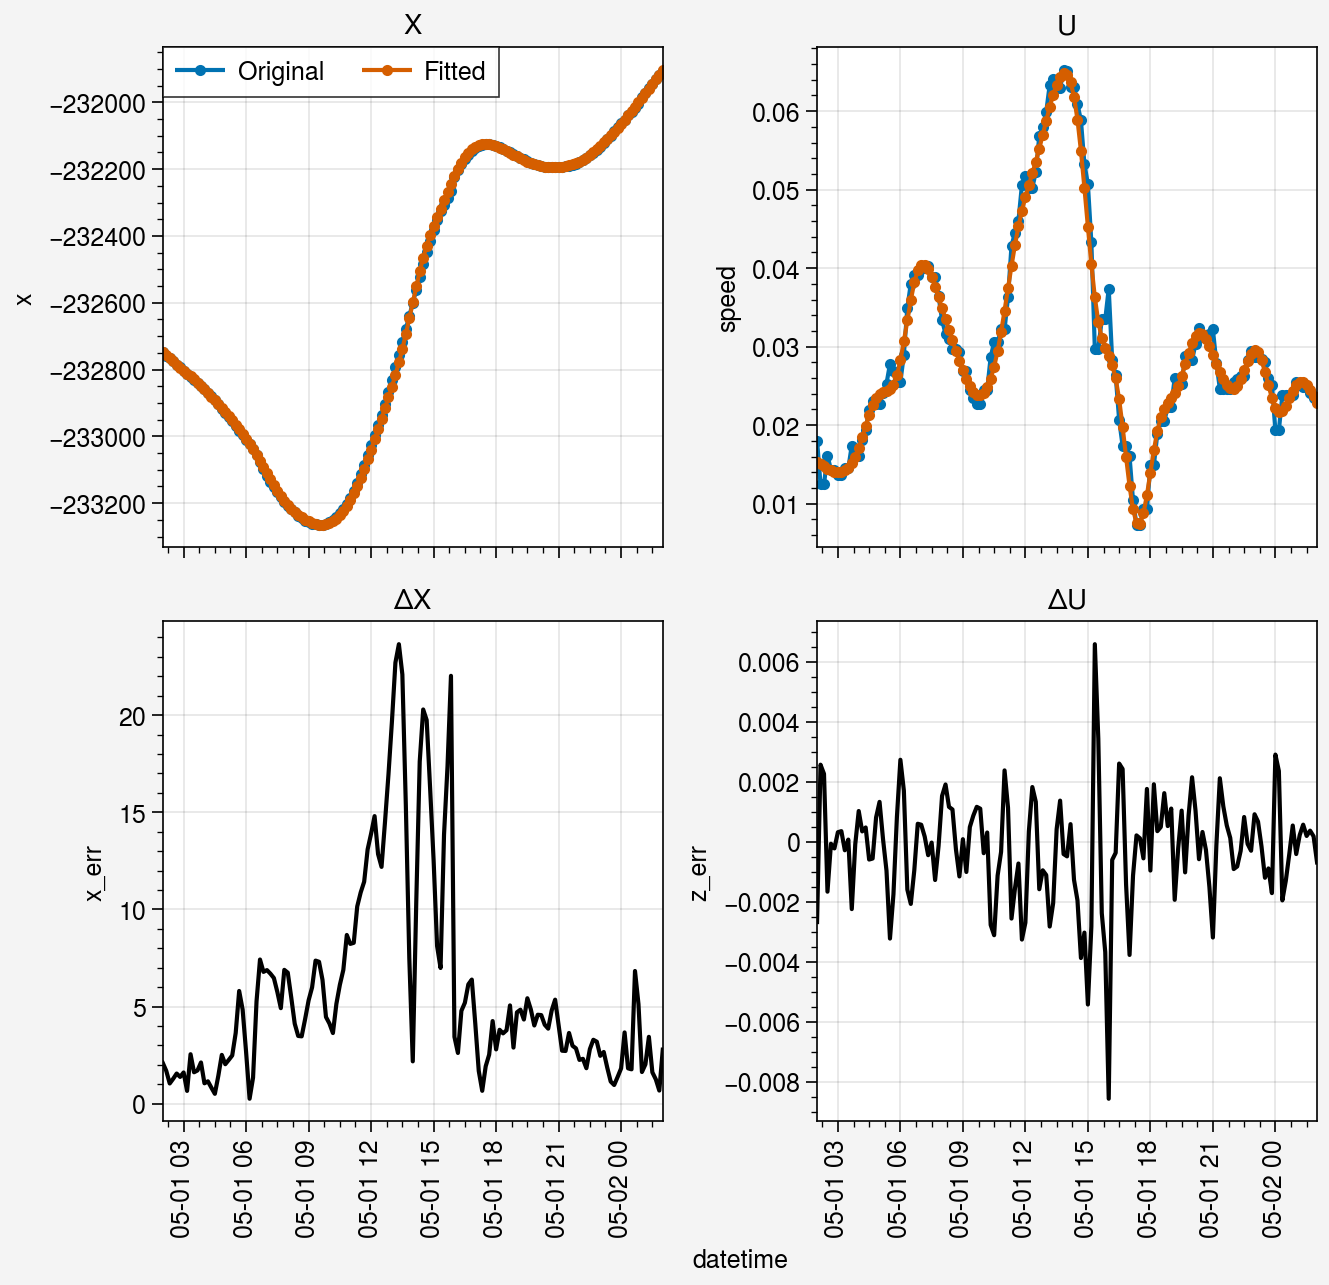

In [303]:
fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False)
ax[0,0].plot(test.x, '.-', label='Original')
ax[0,0].plot(test.x_hat, '.-', label='Fitted')
ax[0,0].format(title='X')
ax[0,0].legend()
ax[0,1].plot(test.speed,'.-')
ax[0,1].plot(test.speed_hat, '.-')
ax[0,1].format(title='U')

ax[1,0].plot(test.x_err, color='k')
ax[1,0].format(title='$\Delta X$')

ax[1,1].plot(test.z_err, color='k')
ax[1,1].format(title='$\Delta U$')



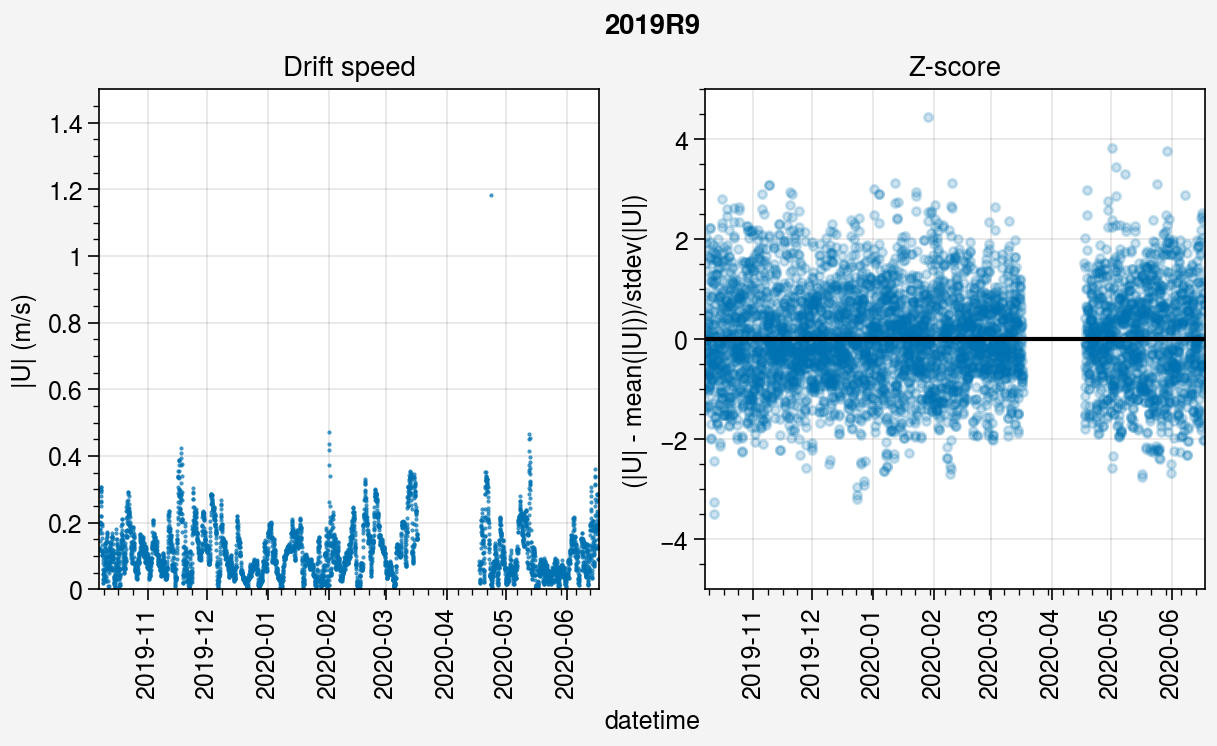

In [123]:
#sm.graphics.tsa.plot_acf(z, lags=80)
fig, ax = pplt.subplots(ncols=2, sharey=False)
buoy_df = buoy_data[buoy]
ax[0].plot(buoy_df['speed'], marker='.', markersize=1, lw=0, alpha=0.75)
ax[0].format(ylim=(0, 1.5), title='Drift speed', ylabel='|U| (m/s)')

ax[1].plot(z, marker='.', lw=0, alpha=0.2)
ax[1].axhline(0, color='k')
ax[1].format(ylim=(-5, 5), title='Z-score', ylabel='(|U| - mean(|U|))/stdev(|U|)')

ax.format(suptitle=buoy)

Creating the test dataset for interpolation errors.

Ideally we could use probability and physics to determine what positions were statistically or physically unlikely. Short of running a model, I'm not sure yet how to go about doing that. Errors in the speed appear to be t-distributed, so I can use 

In [311]:
# Possibly too many degrees of freedom for spline fit.

Timedelta('0 days 12:00:00')

In [7]:
%%time
results = []
for buoy in buoy_data:
    buoy_df = buoy_data[buoy]    
    for date in buoy_df.sample(n=100, random_state=1251).index:
        margin = pd.to_timedelta('24H')
        if len(buoy_df.loc[slice(date-margin, date+margin)]) >= 24:
            test = clean.fit_splines(date, buoy_df.loc[slice(date-margin, date+margin)], 'x', 'y', 'speed')
            xerr = test.loc[date, 'x_err']
            zerr = test.loc[date, 'z_err']
            Z = buoy_df.loc[date, 'z']
            si = buoy_df.loc[date, 'sampling_interval']
            results.append([buoy, si, Z, np.round(xerr, 1), np.round(zerr, 4)])
results_df = pd.DataFrame(results, columns=['BuoyID', 'SamplingInterval', 'Z', 'deltaX', 'deltaU'])

CPU times: user 8min 22s, sys: 11.6 s, total: 8min 33s
Wall time: 5min 44s


In [8]:
iqr = (results_df.groupby('BuoyID').quantile(0.75)['deltaX'] - results_df.groupby('BuoyID').quantile(0.25)['deltaX'])
outlier_threshold = 2.5*iqr + results_df.groupby('BuoyID').quantile(0.5)['deltaX']

In [14]:
%%time
import scipy.stats as stats
alpha = 0.0001

t_thresholds = []
for name, group in results_df.groupby('BuoyID'):
    df, loc, scale = stats.t.fit(trimboth(group.deltaU, 0.01))
    
    lower = stats.t.ppf(alpha, df, loc=loc, scale=scale)
    upper = stats.t.ppf(1-alpha, df, loc=loc, scale=scale) # X s.t. P(x < X) = q
    t_thresholds.append([name, df, loc, scale, lower, upper])

CPU times: user 15.2 s, sys: 164 ms, total: 15.4 s
Wall time: 16.3 s


In [15]:
t_thresholds = pd.DataFrame(t_thresholds, columns=['BuoyID', 'df', 'loc', 'scale', 'lower', 'upper'])

In [16]:
error_thresh = t_thresholds.set_index('BuoyID').merge(outlier_threshold, left_index=True, right_index=True)

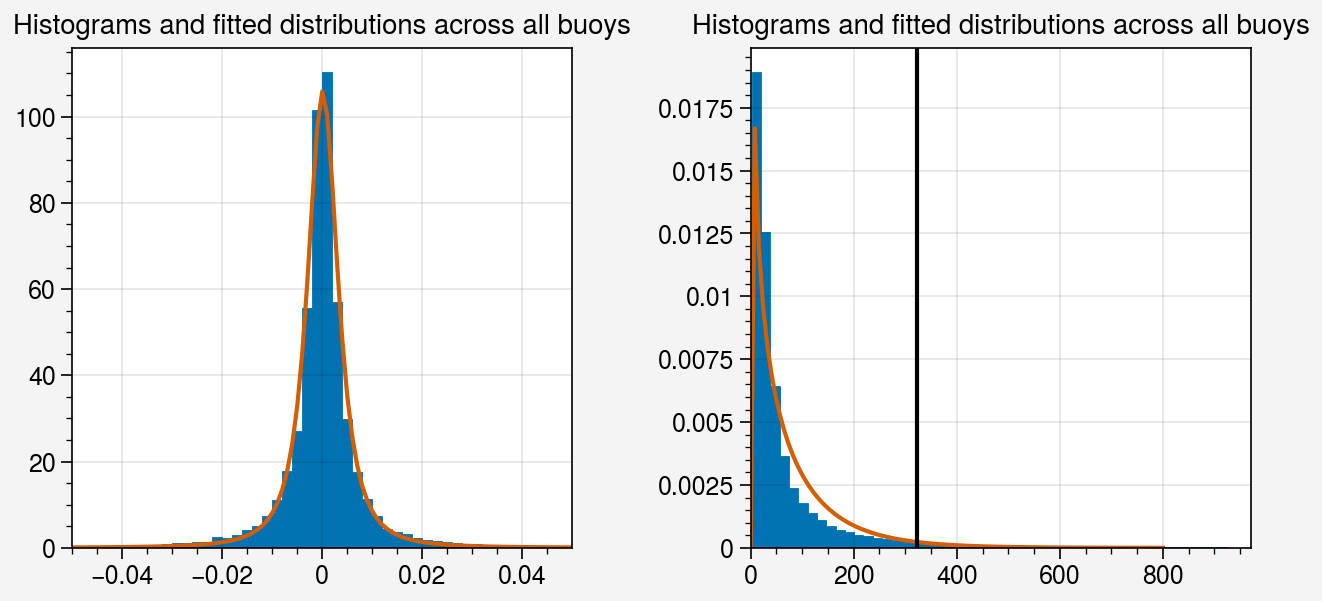

In [353]:
fig, ax = pplt.subplots(ncols=2, share=False)
f = ax[0].hist(trimboth(results_df.deltaU, 0.01), bins=np.linspace(-0.05, 0.05, 51), density=True)
g = ax[1].hist(trimboth((results_df.deltaX), 0.01), bins=51, density=True)
df, loc, scale = stats.t.fit(trimboth(results_df.deltaU, 0.01))
x = np.linspace(-0.05, 0.05, 101)
tdist_pdf = stats.t.pdf(x, df, loc, scale)
ax[0].plot(x, tdist_pdf)

df, loc, scale = stats.chi2.fit(trimboth(results_df.deltaX, 0.01))
x = np.linspace(0, 800, 100)
chi2dist_pdf = stats.chi2.pdf(x, df, loc, scale)
ax[1].plot(x, chi2dist_pdf)
ax.format(title='Histograms and fitted distributions across all buoys')


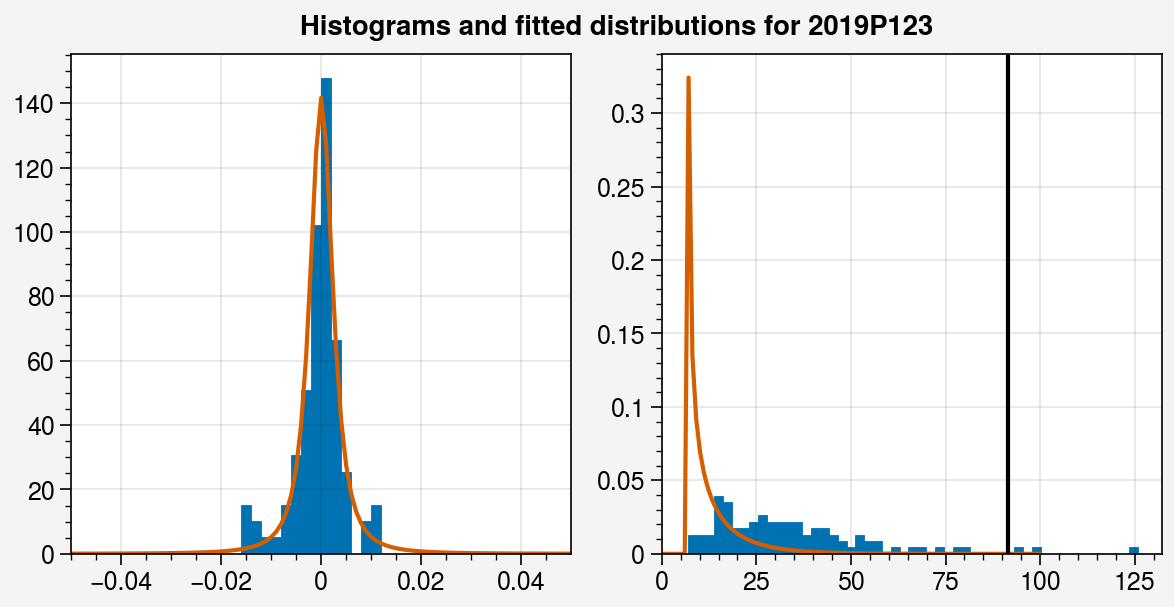

In [362]:
fig, ax = pplt.subplots(ncols=2, share=False)
buoy = '2019P123'
deltaU = results_df.loc[results_df.BuoyID == buoy, 'deltaU']
deltaX = results_df.loc[results_df.BuoyID == buoy, 'deltaX']
f = ax[0].hist(trimboth(deltaU, 0.01), bins=np.linspace(-0.05, 0.05, 51), density=True)
g = ax[1].hist(trimboth((deltaX), 0.01), bins=51, density=True)
df, loc, scale = stats.t.fit(trimboth(deltaU, 0.01))
x = np.linspace(-0.05, 0.05, 101)
tdist_pdf = stats.t.pdf(x, df, loc, scale)
ax[0].plot(x, tdist_pdf)

df, loc, scale = stats.chi2.fit(trimboth(deltaX, 0.01))
x = np.linspace(0, 100, 100)
chi2dist_pdf = stats.chi2.pdf(x, df, loc, scale)
ax[1].plot(x, chi2dist_pdf)
ax[1].axvline(outlier_threshold[buoy], color='k')
ax.format(suptitle='Histograms and fitted distributions for ' + buoy)



In [17]:
%%time
for buoy in buoy_data:
    buoy_data[buoy]['deltaX_flag'] = 0
    buoy_data[buoy]['deltaU_flag'] = 0
    buoy_data[buoy]['deltaX'] = np.nan
    buoy_data[buoy]['deltaU'] = np.nan

    
    idx = buoy_data[buoy].loc[buoy_data[buoy].flag==1].index
    for date in idx:
        check_df = clean.fit_splines(date, buoy_data[buoy].loc[slice(date-margin, date+margin)], 'x', 'y', 'speed')
        if check_df.loc[date, 'x_err'] > error_thresh.loc[buoy, 'deltaX']:
            buoy_data[buoy].loc[date, 'deltaX_flag'] = 1
        if (check_df.loc[date, 'z_err'] < error_thresh.loc[buoy, 'lower']) | (check_df.loc[date, 'z_err'] > error_thresh.loc[buoy, 'upper']):
            buoy_data[buoy].loc[date, 'deltaU_flag'] = 1
        buoy_data[buoy].loc[date, 'deltaU'] = check_df.loc[date, 'z_err']
        buoy_data[buoy].loc[date, 'deltaX'] = check_df.loc[date, 'x_err']
 

CPU times: user 54.9 s, sys: 1.26 s, total: 56.2 s
Wall time: 32.8 s


In [18]:
for buoy in buoy_data:       
    # pass 2
    flag_either = (buoy_data[buoy].deltaU_flag + buoy_data[buoy].deltaX_flag) > 0
    
    buoy_df2 = buoy_data[buoy].where(~flag_either).dropna()
    idx = buoy_df2.loc[buoy_df2.flag==1].index
    for date in idx:
        if len(buoy_df2.loc[slice(date-margin, date+margin)]) > 24:
            check_df = clean.fit_splines(date, buoy_df2.loc[slice(date-margin, date+margin)], 'x', 'y', 'speed')
            # save the updates to the original data
            if check_df.loc[date, 'x_err'] > error_thresh.loc[buoy, 'deltaX']:
                buoy_data[buoy].loc[date, 'deltaX_flag'] = 1
            if (check_df.loc[date, 'z_err'] < error_thresh.loc[buoy, 'lower']) | (check_df.loc[date, 'z_err'] > error_thresh.loc[buoy, 'upper']):
                buoy_data[buoy].loc[date, 'deltaU_flag'] = 1
            buoy_data[buoy].loc[date, 'deltaU'] = check_df.loc[date, 'z_err']
            buoy_data[buoy].loc[date, 'deltaX'] = check_df.loc[date, 'x_err']

In [419]:
num_flagged = {}
for buoy in buoy_data:    
    n = buoy_data[buoy].loc[:, ['flag', 'deltaX_flag', 'deltaU_flag']].sum()
    if np.any(n > 0):
        num_flagged[buoy] = n
nf2 = pd.DataFrame(num_flagged)

In [ ]:
likely_bad = ['2020P237']
checked = ['2019R9', '2020P171']

# 2020P171 has some messy parts in january

In [398]:
num_flagged = {}
for buoy in buoy_data:    
    n = buoy_data[buoy].loc[:, ['flag', 'deltaX_flag', 'deltaU_flag']].sum()
    if np.any(n > 0):
        num_flagged[buoy] = n

In [23]:
buoy_data[buoy].head()

,x,y,sigma_x_regrid,longitude,latitude,sampling_interval,speed,flag,z,deltaX_flag,deltaU_flag,deltaX,deltaU
datetime,,,,,,,,,,,,,
2019-10-07 06:50:00,-394187.01005,-396918.86066,0.124621,135.197853,84.989951,60.0,0.125074,0,-1.054019,0,0,NaN,NaN
2019-10-07 07:10:00,-394161.01662,-397066.68157,0.124621,135.210409,84.989175,60.0,0.119320,0,-1.311683,0,0,NaN,NaN
2019-10-07 08:00:00,-394114.94221,-397421.66529,0.033302,135.239357,84.987207,60.0,0.118350,0,-1.420352,0,0,NaN,NaN
2019-10-07 09:00:00,-394064.37454,-397844.71500,0.028599,135.273511,84.984833,60.0,0.118350,0,-1.496108,0,0,NaN,NaN
2019-10-07 10:00:00,-393996.00350,-398276.17260,0.026514,135.309532,84.982516,60.0,0.121345,0,-1.473983,0,0,NaN,NaN


In [24]:
# Next step
for buoy in buoy_data:
    buoy_df = buoy_data[buoy].copy()

    # Drop flagged observations
    buoy_df = buoy_df.where((buoy_df.deltaX_flag + buoy_df.deltaU_flag) == 0).dropna(subset=['x'])
    
    # Realign to 30 min
    buoy_df = interp.regrid_buoy_track(buoy_df, precision='30min')
    buoy_df = clean.compute_speed(buoy_df, date_index=True, rotate_uv=True, difference='centered')

    buoy_df.to_csv('../data/mosaic_qc/' + metadata.loc[buoy, 'filename'] + '.csv')

2019P203


,x,y,sigma_x_regrid,longitude,latitude,sampling_interval,speed,flag,z,deltaX_flag,deltaU_flag,deltaX,deltaU
datetime,,,,,,,,,,,,,
2020-01-29 02:30:00,-254719.01295,-16887.11109,12.470157,93.792989,87.714322,30.0,0.172520,1,10.235424,1,1,373.310969,-0.125030
2020-02-07 11:00:00,-232099.80601,-6176.45503,0.016101,91.524350,87.921144,30.0,0.017465,1,-5.347824,0,0,15.511525,0.008702
2020-02-07 11:30:00,-232068.37015,-6176.79893,0.011544,91.524641,87.921425,30.0,0.017465,1,-5.583684,0,0,17.440861,0.007014
2020-02-09 22:00:00,-219715.40231,-296.29641,0.007496,90.077266,88.032774,30.0,0.120658,1,4.702204,0,0,7.118438,-0.021482
2020-03-01 20:00:00,-75296.70951,179825.97093,0.001184,22.720030,88.254499,30.0,0.034352,1,-4.737030,1,0,197.200252,0.000597
2020-03-01 20:30:00,-75332.12035,179876.66136,0.000947,22.723874,88.253958,30.0,0.034352,1,-4.570660,0,0,27.005320,0.000652
2020-03-01 21:00:00,-75361.86808,179931.94395,0.001166,22.725661,88.253399,30.0,0.034877,1,-4.071597,1,0,162.464914,0.001261
2020-04-12 17:00:00,-143159.49332,636023.00138,3.149611,12.685041,84.160468,30.0,1.338271,1,146.662132,1,1,2469.306110,-1.337089
2020-05-01 09:00:00,-183491.07734,666940.21736,0.116246,15.382842,83.803734,30.0,0.077606,1,4.696424,1,1,135.646872,-0.057755


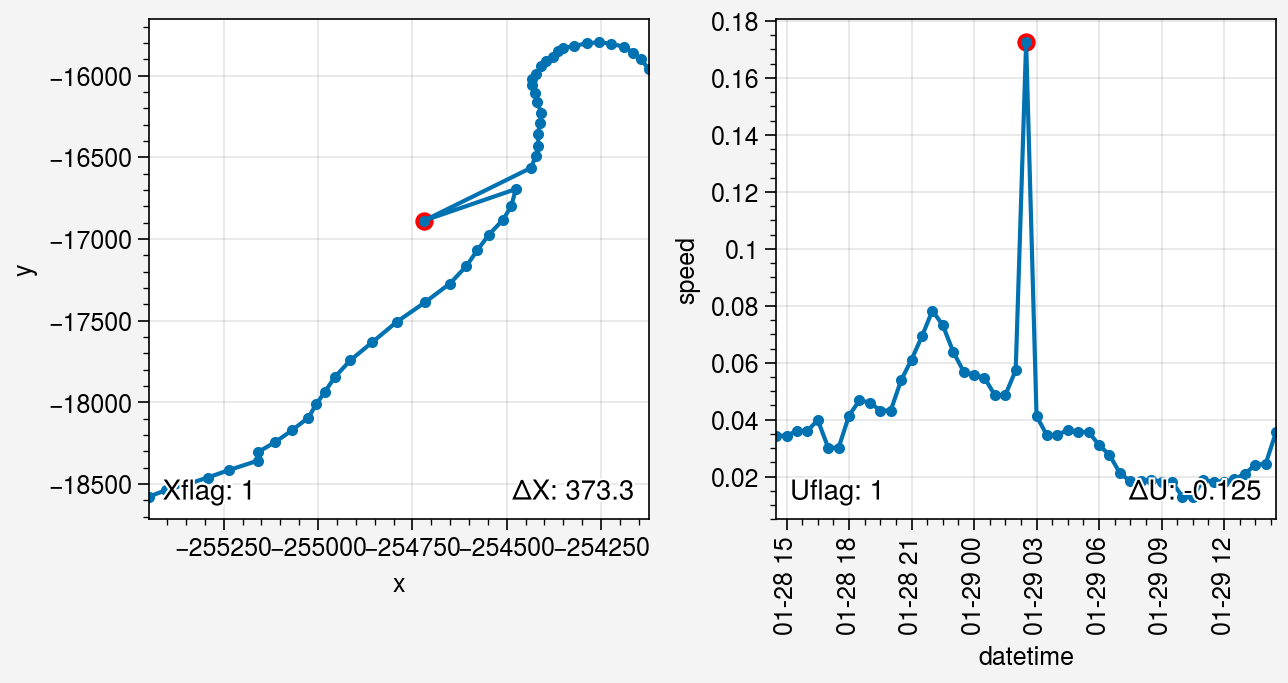

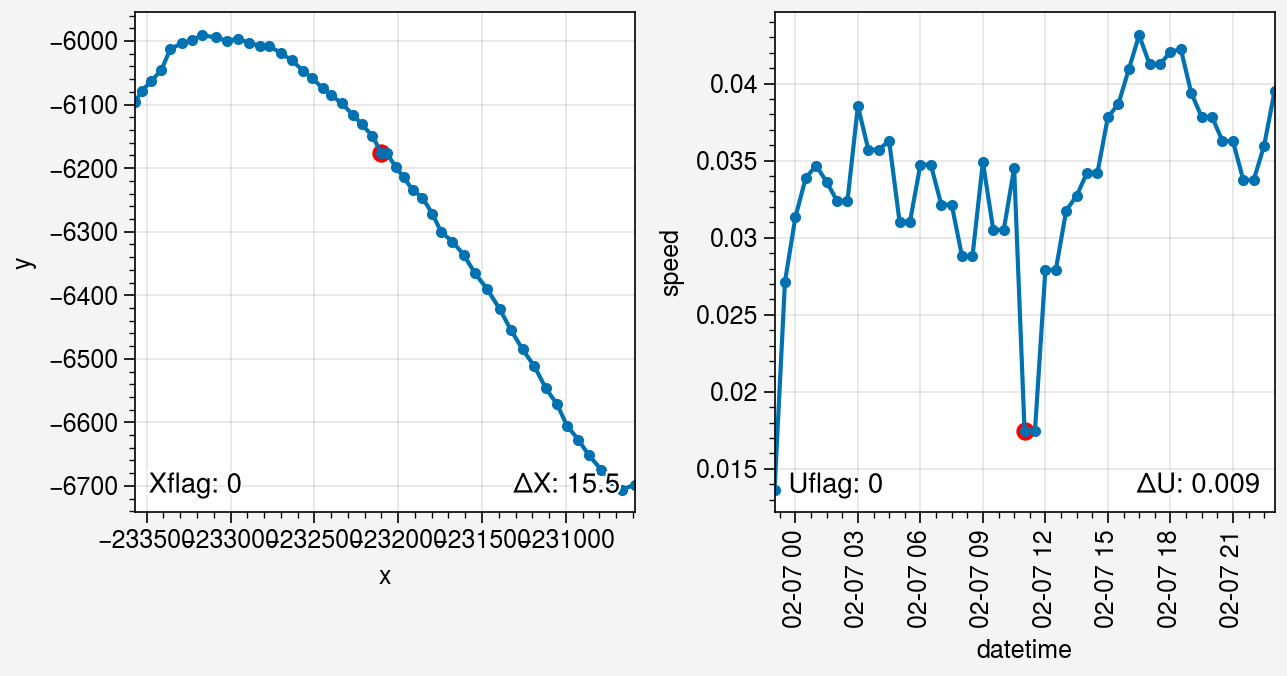

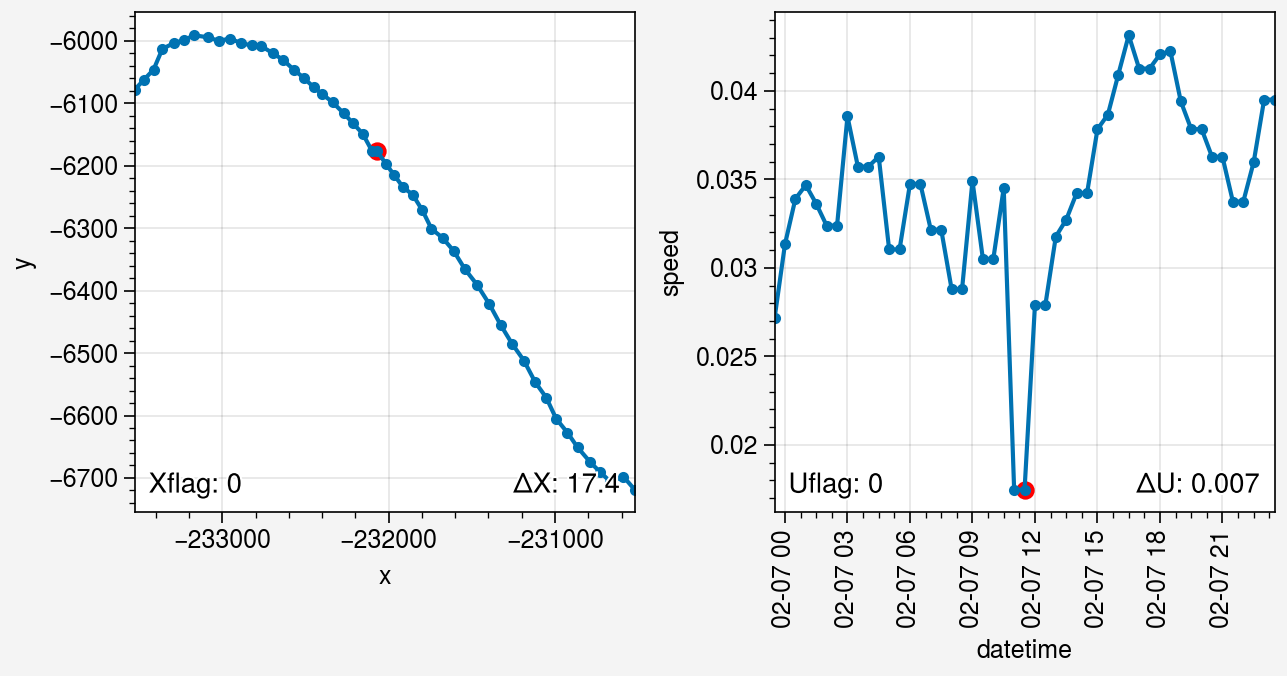

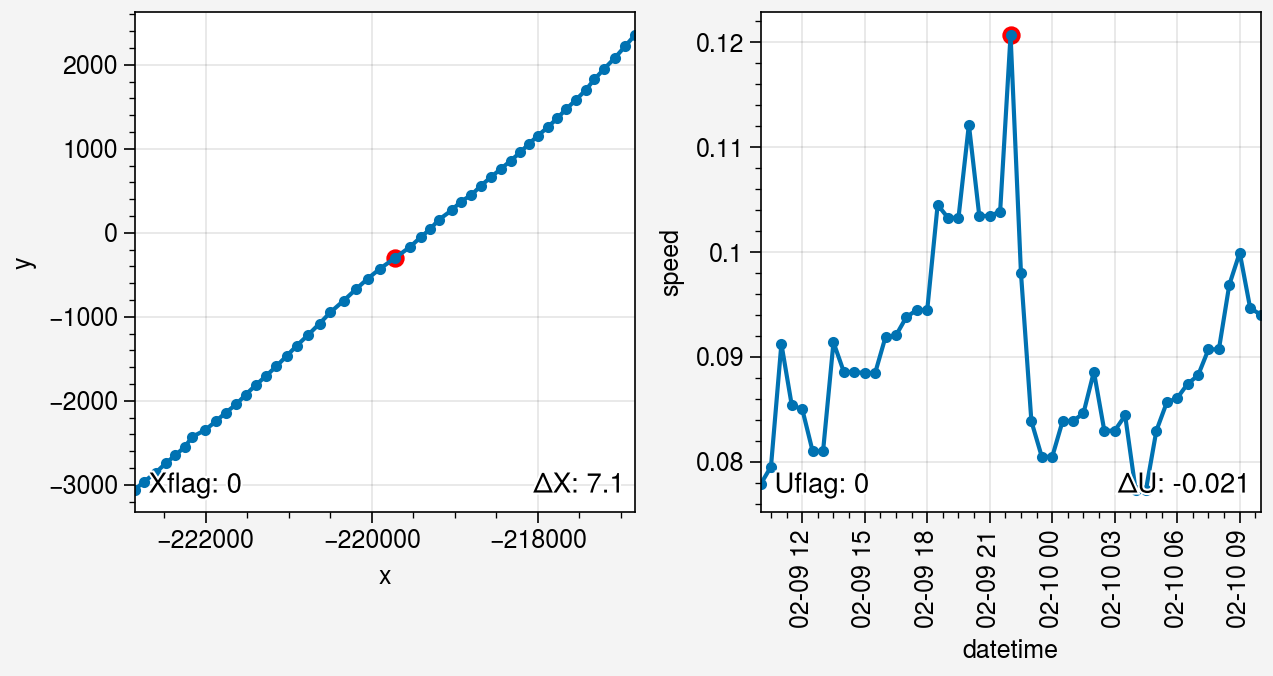

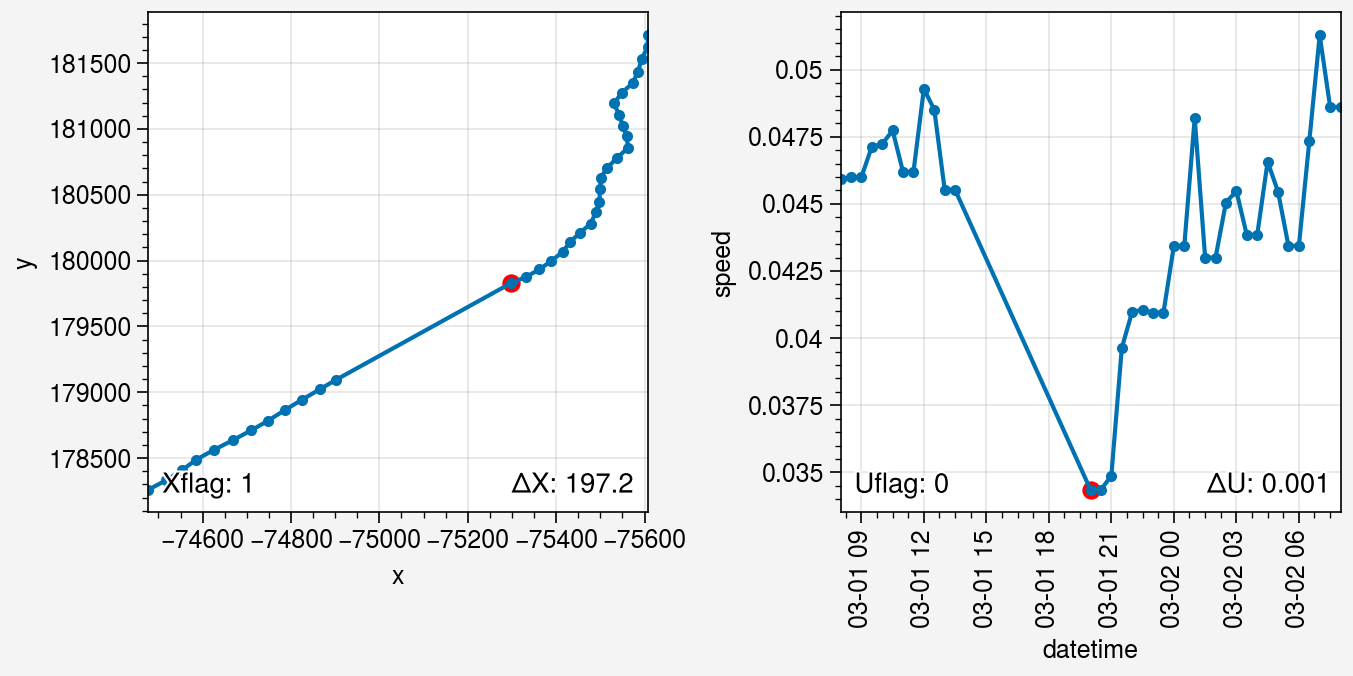

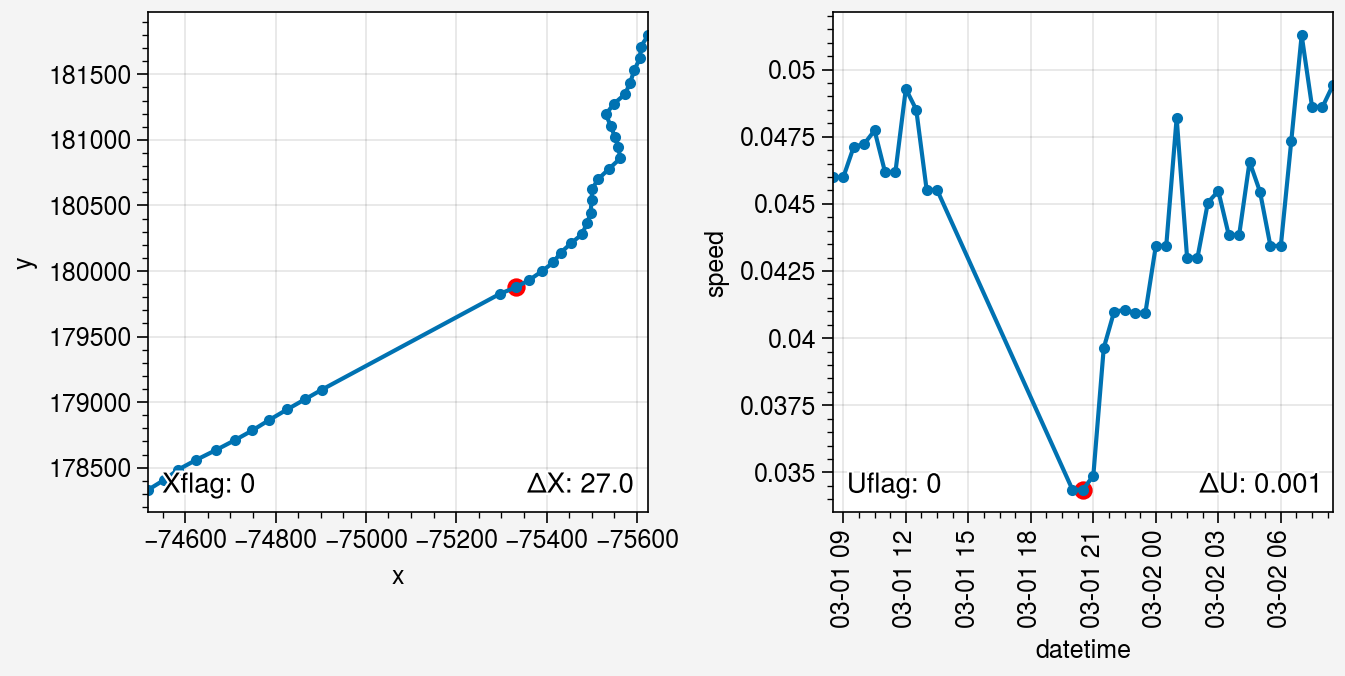

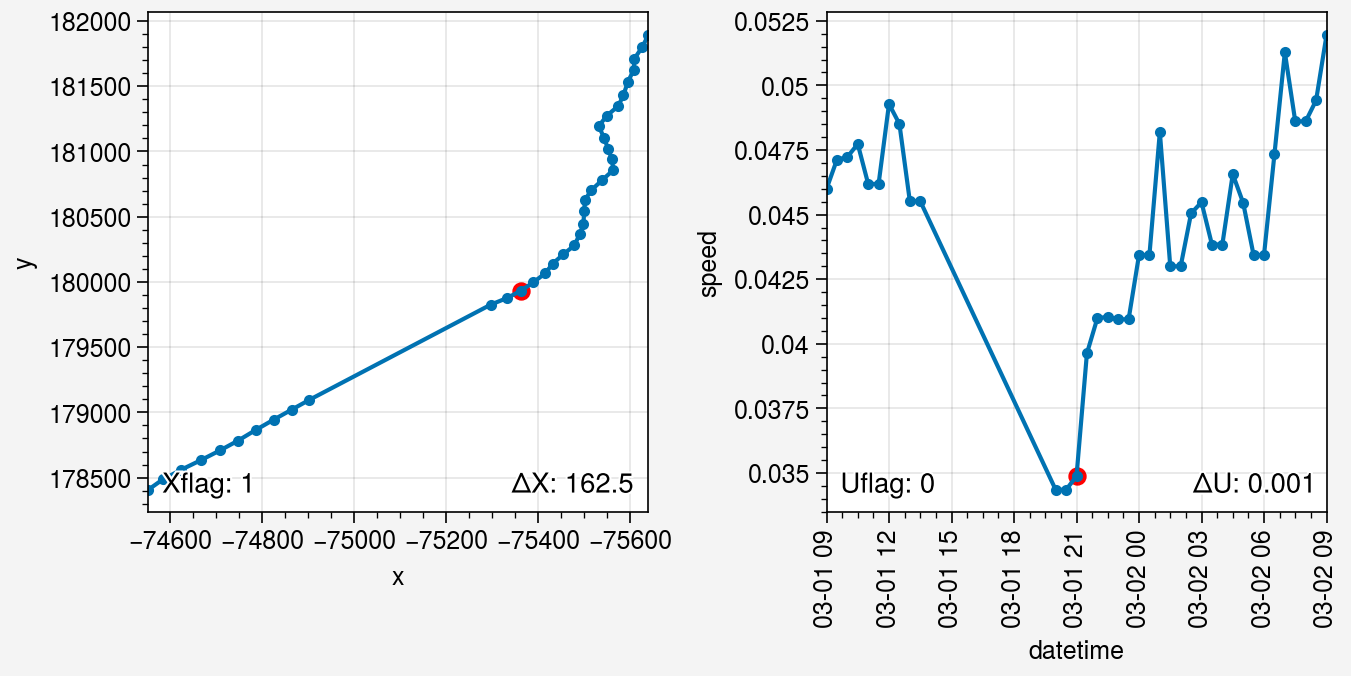

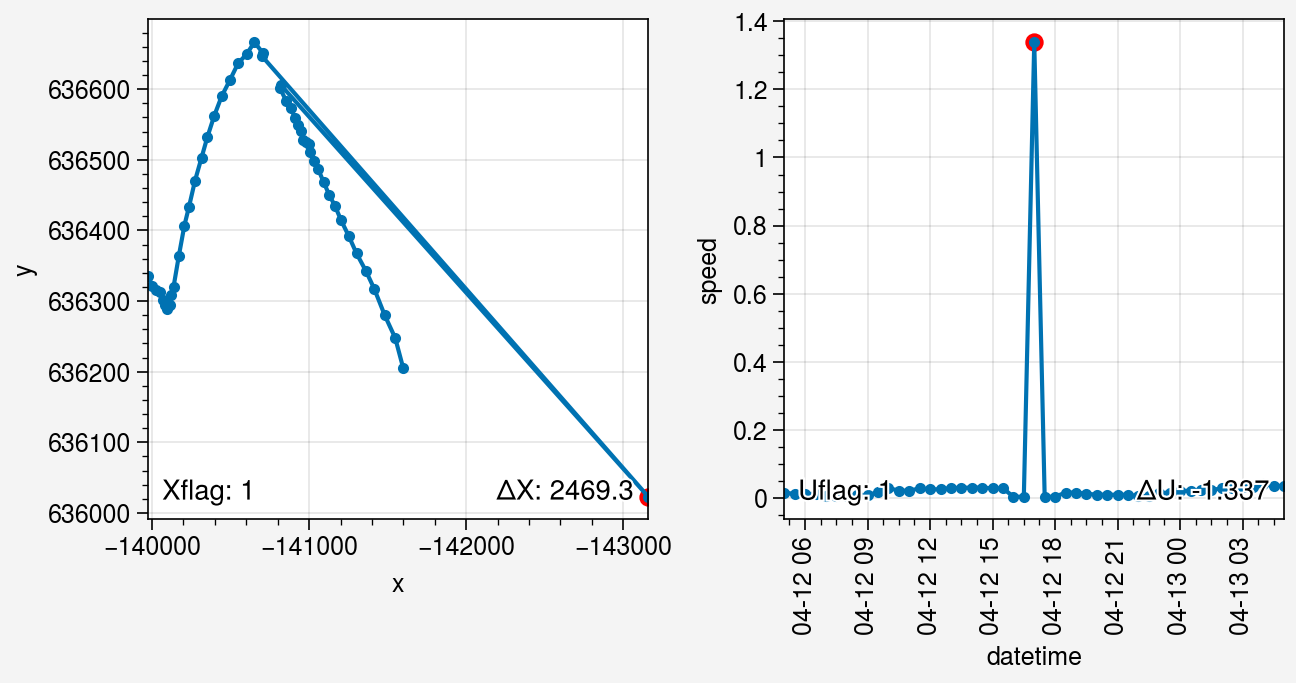

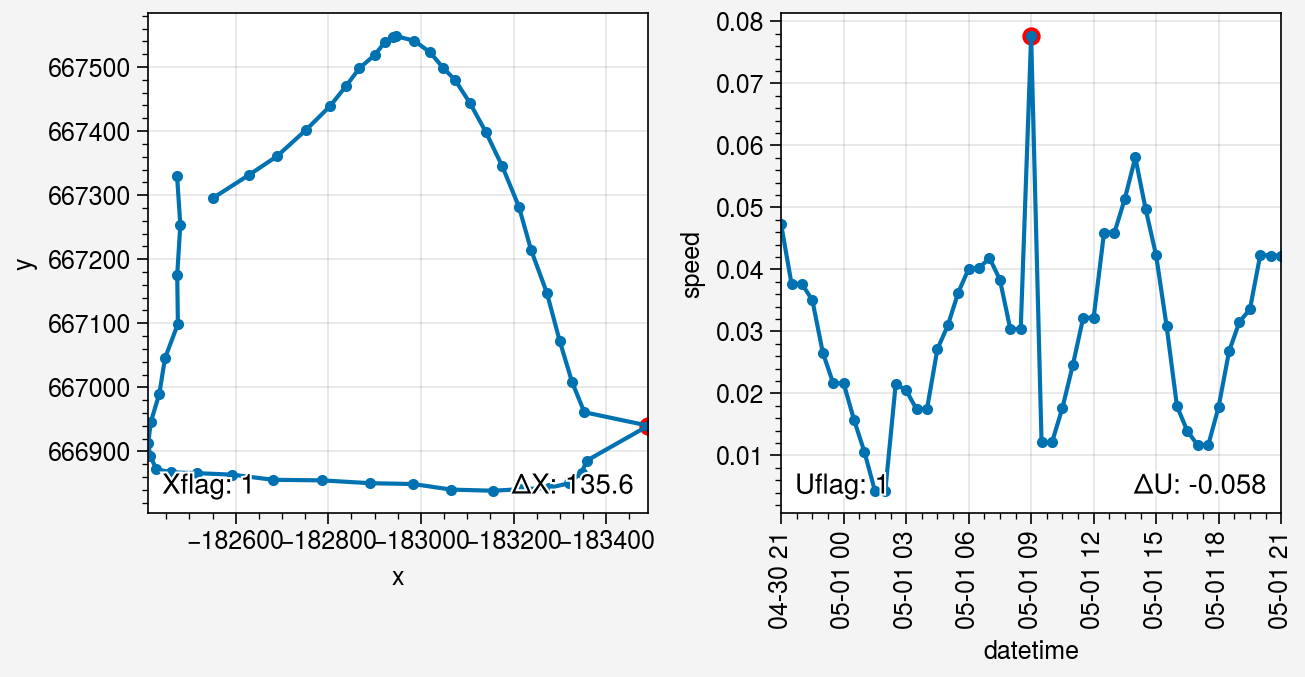

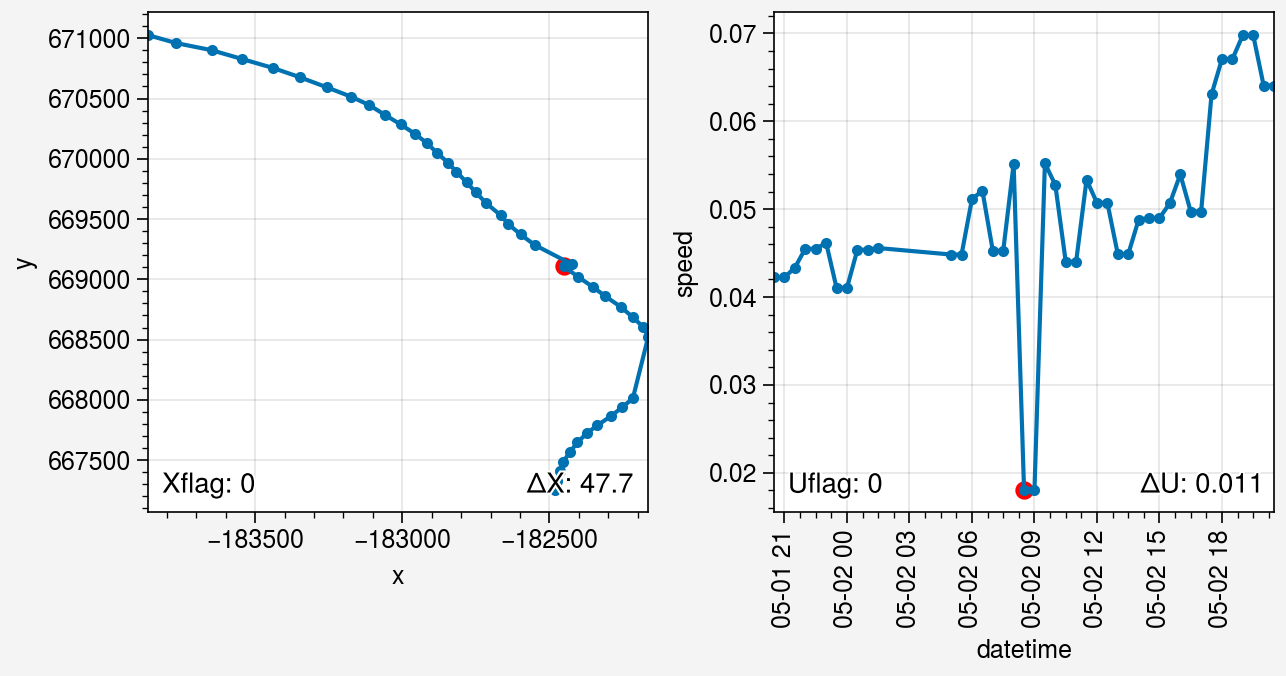

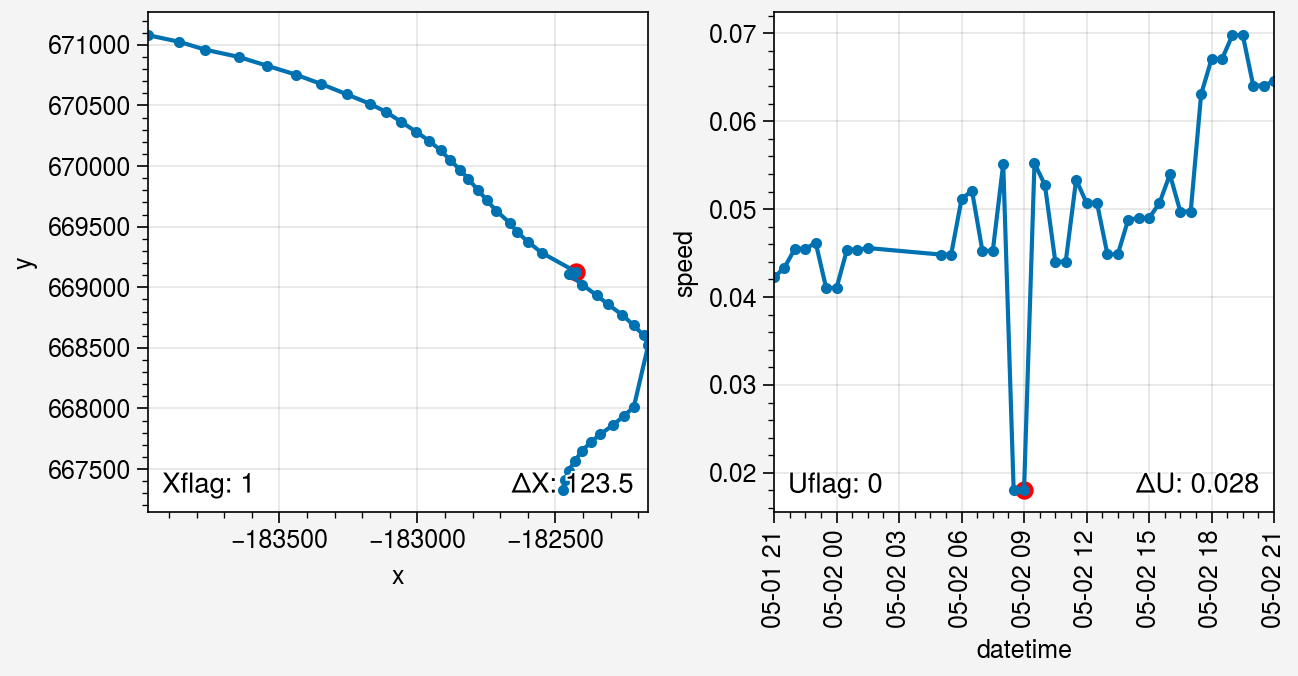

In [427]:
buoy = '2019P203'
print(buoy)
buoy_df = buoy_data[buoy]
z = buoy_df['z']

idx = buoy_df.loc[buoy_df['flag']==1].index
margin = pd.to_timedelta('12H')
for date in idx:
    fig, ax = pplt.subplots(ncols=2, share=False)
    ax[0].plot(buoy_df.loc[slice(date-margin, date+margin), 'x'],
            buoy_df.loc[slice(date-margin, date+margin), 'y'], marker='.')
    ax[0].scatter(buoy_df.loc[date, 'x'], buoy_df.loc[date, 'y'], color='r')
    ax[1].plot(buoy_df.loc[slice(date-margin, date+margin), 'speed'], marker='.')
    ax[1].scatter(date, buoy_df.loc[date, 'speed'], color='r')
    ax[0].format(lltitle='Xflag: ' + str(buoy_df.loc[date, 'deltaX_flag']))
    ax[0].format(lrtitle='$\Delta X$: ' + str(buoy_df.loc[date, 'deltaX'].round(1)))

    ax[1].format(lltitle='Uflag: ' + str(buoy_df.loc[date, 'deltaU_flag']))    
    ax[1].format(lrtitle='$\Delta U$: ' + str(buoy_df.loc[date, 'deltaU'].round(3)))
#     ax[2].plot(z.loc[slice(date-margin, date+margin)], marker='.')
#     ax[2].scatter(date, z.loc[date], color='r')

buoy_data[buoy].loc[buoy_data[buoy].flag==1]

In [395]:
error_thresh.loc[buoy]

df          2.085462
loc        -0.000265
scale       0.002862
lower      -0.174874
upper       0.174345
deltaX    114.437500
Name: 2020P171, dtype: float64

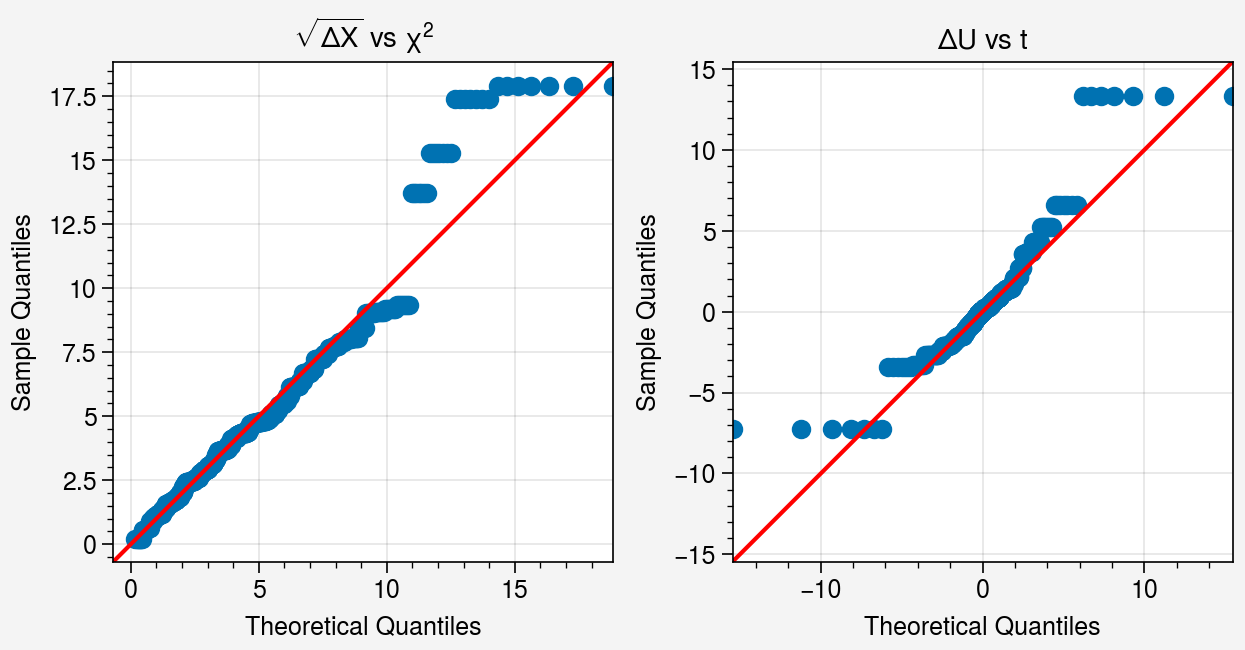

In [265]:
# Weirdly, it looks like the square root of the distances follows a chi2, but maybe not.
fig, ax = pplt.subplots(ncols=2, share=False)
dof, loc, scale = stats.chi2.fit(np.sqrt(results_df.deltaX))
x = sm.qqplot(np.sqrt(results_df.deltaX), dist=stats.chi2, distargs=dof, loc=loc, scale=scale,
              fit=True, ax=ax[0], line='45')
ax[0].format(title='$\sqrt{\Delta X}$ vs $\chi^2$')

dof, loc, scale = stats.t.fit(trimboth(results_df.deltaU, 0.01))
x = sm.qqplot(results_df.deltaU[results_df.deltaU < 1e3].dropna(), dist=stats.t, distargs=dof, loc=loc, scale=scale,
              fit=True, ax=ax[1], line='45')
ax[1].format(title='$\Delta U$ vs $t$')

<a list of 1 Line2D objects>

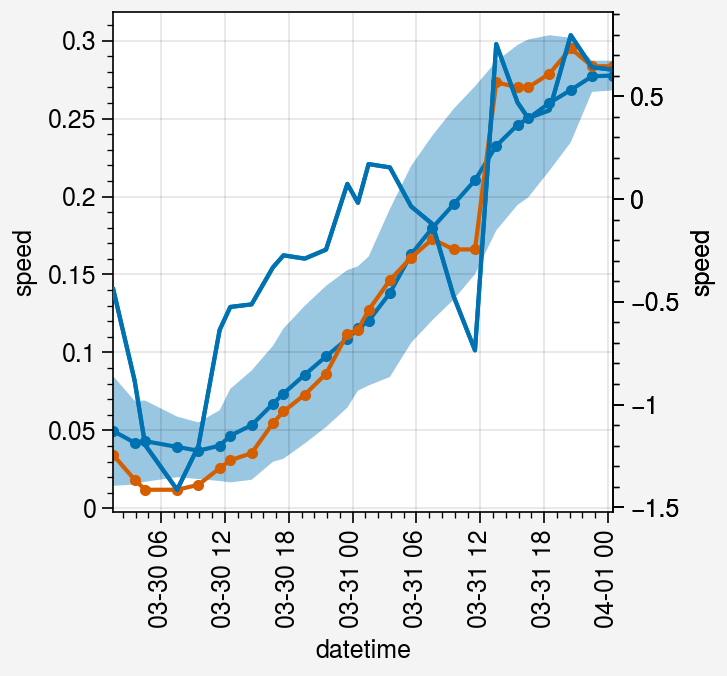

In [8]:
date = pd.to_datetime('2020-03-31 01:00:00')
margin = pd.to_timedelta('24H')
fig, ax = pplt.subplots()
timeslice = slice(date-margin, date+margin)
ax.plot(trim_mean.loc[timeslice], marker='.', shadedata=trim_std.loc[timeslice])
ax.plot(buoy_df.speed.loc[timeslice], marker='.')
ax2 = ax.twinx()
ax2.plot(((buoy_df.speed - trim_mean)/trim_std).loc[timeslice])

In [ ]:
# Use the trimmed standard deviation to find places where the speed is fully a spike


In [44]:
for buoy in buoy_data:
    data = buoy_data[buoy].copy()

    data['flag_dup'] = clean.flag_duplicates(data, date_index=True)
    data['flag_date'] = clean.check_dates(data, date_index=True)
    data['flag_speed'] =  clean.check_speed(data.copy(), date_index=True, method='z-score', sigma=6, window='3D')
    #data = data.where(~(check_dup | check_dates)).dropna()
    data = clean.compute_speed(data, date_index=True, difference='backward')    
    #data['speed_flag'] = clean.check_speed(data, date_index=True, method='z-score', sigma=6, window='3D')

    buoy_data[buoy] = data #data.where(~data.speed_flag).dropna()



In [19]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [95]:
# Start with only a small number of outliers
for buoy in buoy_data:
    buoy_data[buoy]['outlier'] = False
    data = buoy_data[buoy]
    fwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='forward')['speed']   
    bwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='backward')['speed']   
    speed = pd.DataFrame({'b': bwd_speed, 'f': fwd_speed}).min(axis=1)
    buoy_data[buoy]['speed_bf'] = speed


In [200]:
def dist_from_median(xvar, yvar, data, window):
    """Computes the distance of the point from the median of a moving window."""
    xa = data[xvar] - data[xvar].rolling(window, center=True).median()
    ya = data[yvar] - data[yvar].rolling(window, center=True).median()
    
    return np.sqrt(xa**2 + ya**2)

<AxesSubplot:xlabel='datetime'>

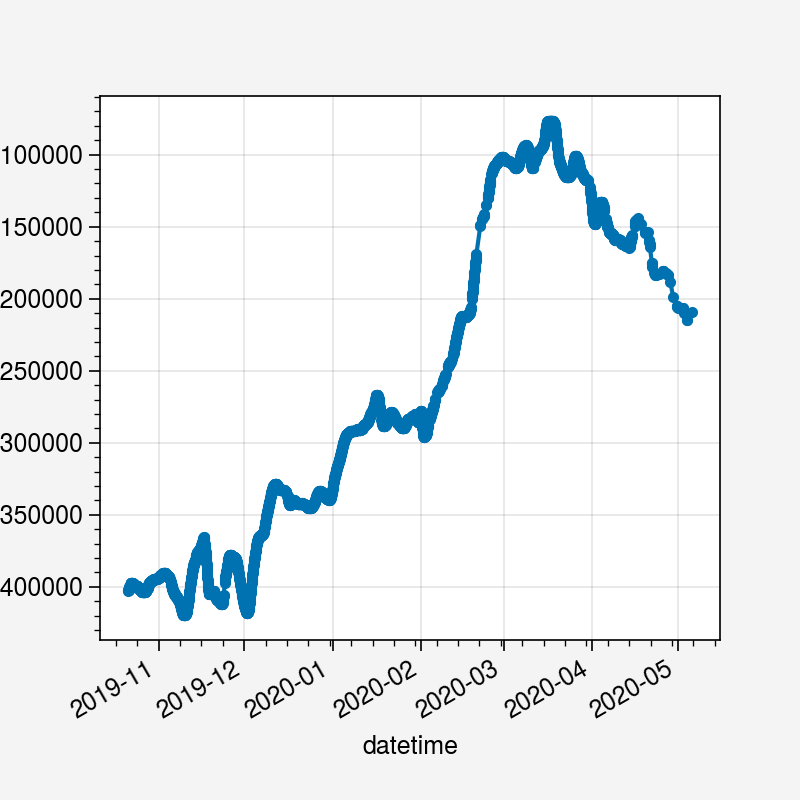

In [89]:
# Example outliers
# timeslice = slice('2020-04-23', '2020-04-24')
# buoy_data['2019R9'].x.loc[timeslice].plot(marker='.')

# timeslice = slice('2020-04-23', '2020-04-24')
buoy_data['2019P151'].x.loc[timeslice].plot(marker='.')

In [64]:
buoy_data['2019R9'].loc['2020-04-23 11:01:09', 'outlier'] = True

In [165]:
# Constructing variables
buoy = '2019R9'
#buoy = '2019P151'
data = buoy_data[buoy].copy()
var_dict = {}
for variable in ['x', 'y', 'speed_bf']:
    var_dict[variable + '_anomaly_3n'] = data[variable] - data[variable].rolling(3, center=True).median()
    var_dict[variable + '_anomaly_6H'] = data[variable] - data[variable].rolling('6H', center=True).median()
    var_dict[variable + '_zscore_3D'] = (data[variable] - data[variable].rolling('3D', center=True).mean())/data[variable].rolling('3D', center=True).std()
    var_dict[variable + '_zscore_12D'] = (data[variable] - data[variable].rolling('12D', center=True).mean())/data[variable].rolling('3D', center=True).std()
var_dict['outlier'] = data['outlier'].astype(int)

In [166]:
test_df = pd.DataFrame(var_dict)
test_df['xy_zscore_3D'] = test_df[['x_zscore_3D', 'y_zscore_3D']].max(axis=1)
test_df['xy_zscore_12D'] = test_df[['x_zscore_12D', 'y_zscore_12D']].max(axis=1)
test_df['xy_anomaly_3n'] = test_df[['x_anomaly_3n', 'y_anomaly_3n']].max(axis=1)
test_df['xy_anomaly_6H'] = test_df[['x_anomaly_6H', 'y_anomaly_6H']].max(axis=1)


<AxesSubplot:xlabel='datetime'>

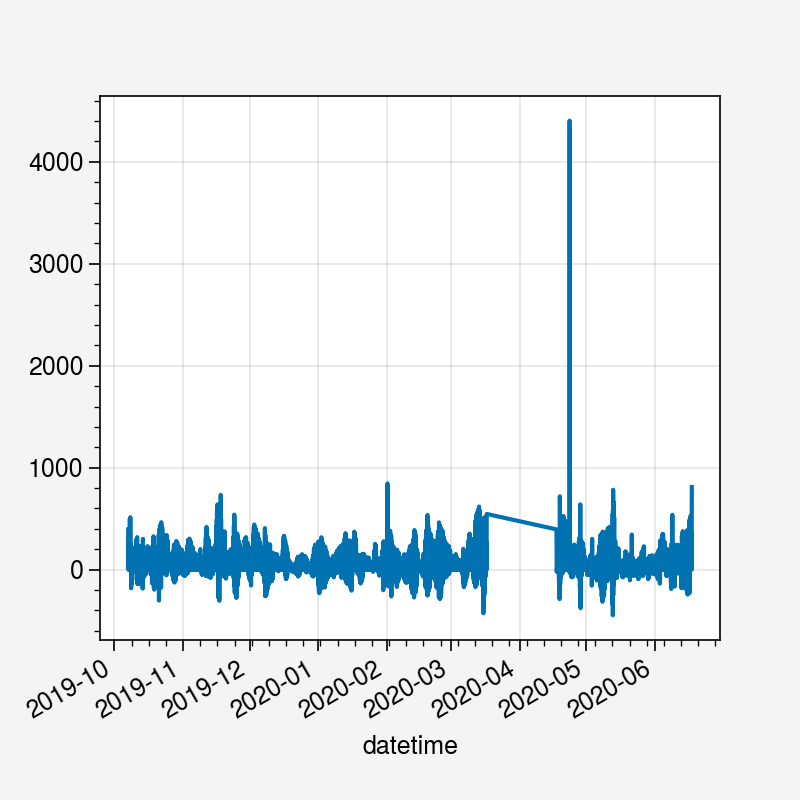

In [199]:
test_df[['x_anomaly_6H', 'y_anomaly_6H']].max(axis=1).plot()

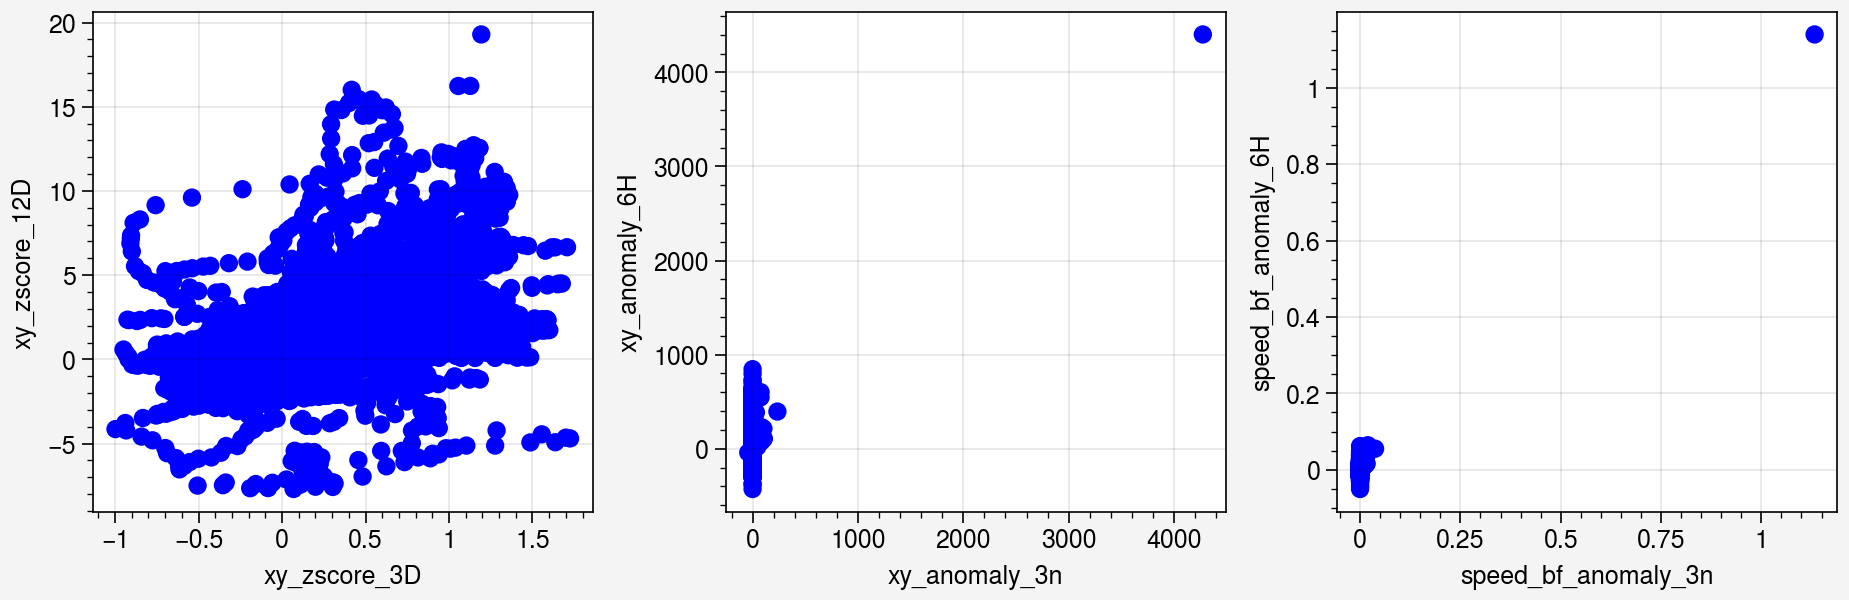

In [168]:
fig, ax = pplt.subplots(ncols=3, share=False)
timeslice=slice('2019-01-01', '2020-05-05')
ax[0].scatter(x='xy_zscore_3D', y='xy_zscore_12D', c='outlier', cmap='bwr', data=test_df.loc[timeslice])
ax[1].scatter(x='xy_anomaly_3n', y='xy_anomaly_6H', c='outlier', cmap='bwr', data=test_df.loc[timeslice])
ax[2].scatter(x='speed_bf_anomaly_3n', y='speed_bf_anomaly_6H', c='outlier', cmap='bwr', data=test_df.loc[timeslice])

In [169]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [170]:
test_df.head()

,x_anomaly_3n,x_anomaly_6H,x_zscore_3D,x_zscore_12D,y_anomaly_3n,y_anomaly_6H,y_zscore_3D,y_zscore_12D,speed_bf_anomaly_3n,speed_bf_anomaly_6H,speed_bf_zscore_3D,speed_bf_zscore_12D,outlier,xy_zscore_3D,xy_zscore_12D,xy_anomaly_3n,xy_anomaly_6H
datetime,,,,,,,,,,,,,,,,,
2019-10-07 06:01:42,NaN,-73.216724,-1.402079,2.640096,NaN,393.614205,1.421903,2.518322,NaN,0.002411,-1.040573,0.169871,0,1.421903,2.640096,NaN,393.614205
2019-10-07 06:46:08,0.0,-25.791796,-1.363480,2.716417,0.0,141.971774,1.383533,2.480558,0.0,0.004821,-1.040573,0.172887,0,1.383533,2.716417,0.0,141.971774
2019-10-07 07:05:15,0.0,-26.757153,-1.335066,2.787504,0.0,202.593088,1.383965,2.427814,0.0,-0.001122,-1.081149,0.099294,0,1.383965,2.787504,0.0,202.593088
2019-10-07 08:02:12,0.0,26.757153,-1.277575,2.864709,0.0,-202.593088,1.354449,2.348790,0.0,-0.002870,-1.079182,0.073213,0,1.354449,2.864709,0.0,26.757153
2019-10-07 09:01:54,0.0,0.000000,-1.210155,2.924448,0.0,0.000000,1.324380,2.272757,0.0,-0.003993,-1.047945,0.073295,0,1.324380,2.924448,0.0,0.000000


In [191]:
#centers = [[1, 1], [-1, -1], [1, -1]]
#X, labels_true = make_blobs(
#    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
#)

X = test_df.loc[timeslice,['xy_anomaly_3n', 'xy_anomaly_6H', 'xy_zscore_12D', 'speed_bf_anomaly_3n']].dropna()
index = X.index
X = X.values

X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=2, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)
# )
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


Estimated number of clusters: 2
Estimated number of noise points: 0


In [192]:
X[:,3]

array([-0.12143767, -0.11550783, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.10677168, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.0941867 , -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.01700324, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143509, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.11506102, -0.12143767,
       -0.12143767, -0.12143767, -0.12023361, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767,  8.42540359,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.08

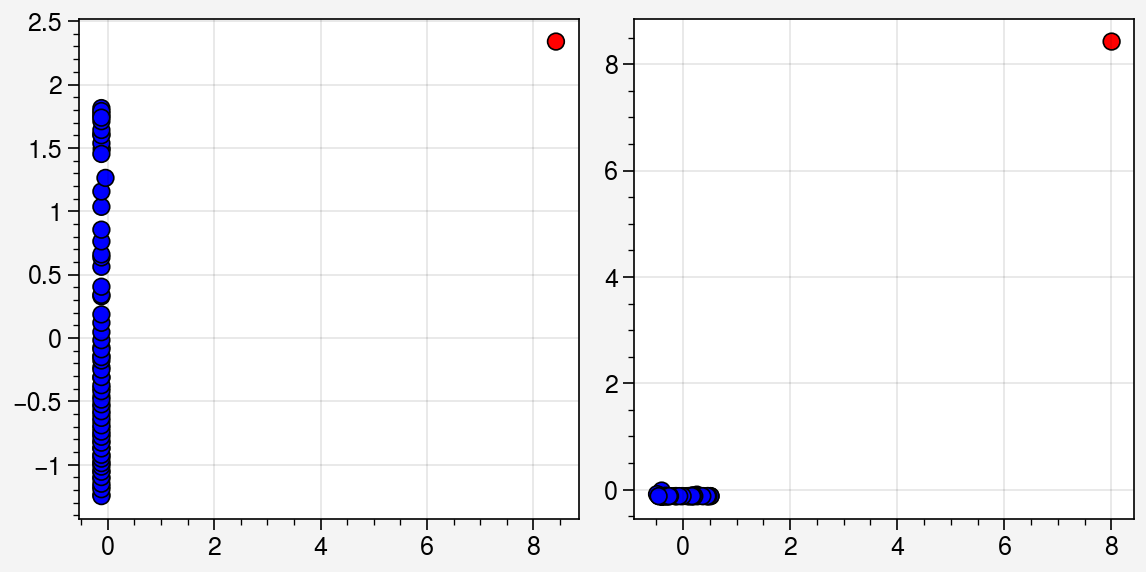

In [193]:
fig, axs = pplt.subplots(ncols=2, share=False)
axs[0].scatter(X[:,0], X[:,2], c=labels, edgecolor='k', cmap='bwr')
axs[1].scatter(X[:,1], X[:,3], c=labels, edgecolor='k', cmap='bwr')

In [194]:
buoy_data[buoy].loc[index].loc[labels==1]

,latitude,longitude,flag_dup,flag_date,flag_speed,x,y,u,v,speed,speed_flag,outlier,speed_bf
datetime,,,,,,,,,,,,,
2020-04-23 11:01:09,84.0837,16.63491,False,False,True,-189082.192326,632854.943701,-0.181787,1.280185,1.293028,False,False,1.182347


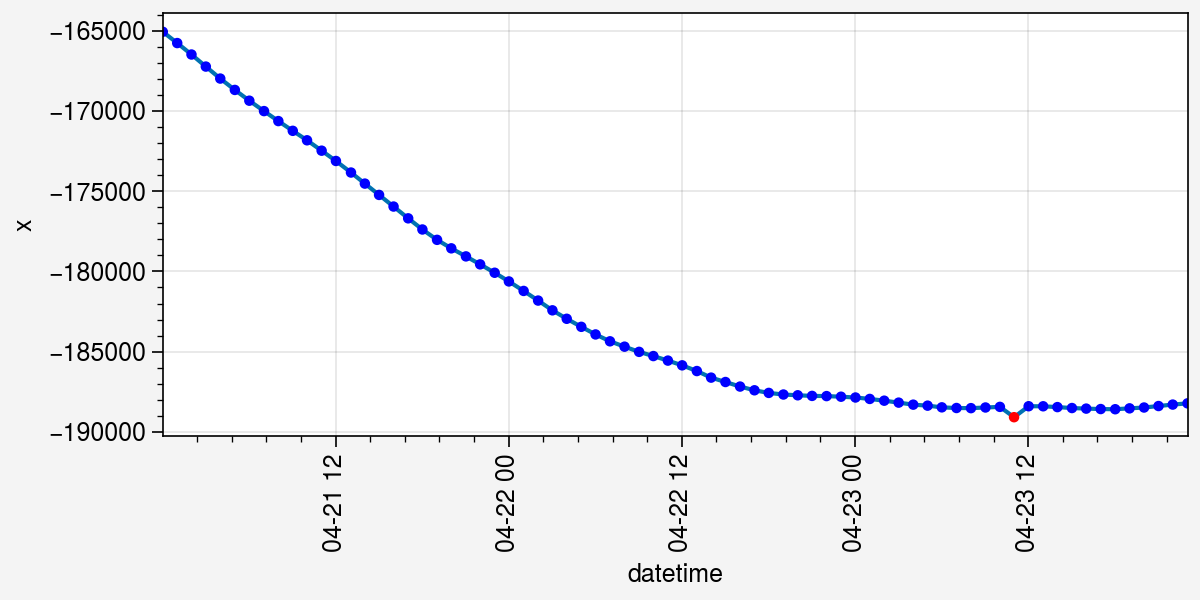

In [195]:
timeslice = slice('2020-04-21', '2020-04-23')
data = buoy_data[buoy].loc[index]
data['class'] = labels
data = data.loc[timeslice]

fig, ax = pplt.subplots(width=6, height=3)
ax.plot(data.index, data.loc[:, 'x'], zorder=0)
ax.scatter(data.index, data.loc[:, 'x'], c=data['class'], cmap='bwr', markersize=10)

In [136]:
buoy_data[buoy].loc[timeslice].shape

(3820, 13)

In [137]:
len(labels)

3818